In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread_collection
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import umap
import warnings
warnings.filterwarnings('ignore')

C:\Users\prath\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\prath\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\prath\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_damage = imread_collection("./Processed_Images/train/damage/*.jpeg")
train_no_damage = imread_collection("./Processed_Images/train/no_damage/*.jpeg")

train_images = np.empty(shape=(10000, 16385))
for i in range(5000):
    img = list(train_damage[i].flatten()) + [1]
    train_images[i] = img
for i in range(5000):
    img = list(train_no_damage[i].flatten()) + [0]
    train_images[5000+i] = img

np.random.shuffle(train_images)
train_X, train_y = train_images[:, :16384], train_images[:, -1]

In [3]:
test_damage = imread_collection("./Processed_Images/test/no_damage/*.jpeg")
test_no_damage = imread_collection("./Processed_Images/test/no_damage/*.jpeg")

test_images = np.empty(shape=(2000, 16385))
for i in range(1000):
    img = list(test_damage[i].flatten()) + [1]
    test_images[i] = img
for i in range(1000):
    img = list(test_no_damage[i].flatten()) + [0]
    test_images[1000+i] = img
    
np.random.shuffle(test_images)
test_X, test_y = test_images[:, :16384], test_images[:, -1]

In [4]:
val_damage = imread_collection("./Processed_Images/val/damage/*.jpeg")
val_no_damage = imread_collection("./Processed_Images/val/no_damage/*.jpeg")

val_images = np.empty(shape=(2000, 16385))
for i in range(1000):
    img = list(val_damage[i].flatten()) + [1]
    val_images[i] = img
for i in range(1000):
    img = list(val_no_damage[i].flatten()) + [0]
    val_images[1000+i] = img
    
np.random.shuffle(val_images)
val_X, val_y = val_images[:, :16384], val_images[:, -1]

### Principal Component Analysis

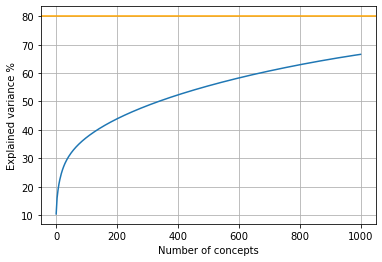

In [5]:
pca = PCA(n_components=1000, random_state=0)
pca.fit(train_X)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')
plt.axhline(y=80, color='orange')

### UMAP with 2 components

In [6]:
# Let's create the object
reducer = umap.UMAP(n_neighbors=15,              # Number of neareast neighbours to use. 
                    n_components=20,             # Number of components. UMAP is robust to larger values
                    metric='hellinger',          # Metric to use.
                    n_epochs=None,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=0,              # Random seed
                    verbose=True                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_train = reducer.fit_transform(train_X)
UMAP_test = reducer.transform(test_X)
UMAP_val = reducer.transform(val_X)

UMAP(angular_rp_forest=True, metric='hellinger', n_components=20, random_state=0, verbose=True)
Fri May  5 12:00:35 2023 Construct fuzzy simplicial set
Fri May  5 12:00:36 2023 Finding Nearest Neighbors
Fri May  5 12:00:36 2023 Building RP forest with 10 trees
Fri May  5 12:00:52 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	Stopping threshold met -- exiting after 8 iterations
Fri May  5 12:01:30 2023 Finished Nearest Neighbor Search
Fri May  5 12:01:35 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri May  5 12:02:09 2023 Finished embedding
Fri May  5 12:02:11 2023 Worst tree score: 0.16010000
Fri May  5 12:02:11 2023 Mean tree score: 0.16434000
Fri May  5 12:02:11 2023 Best tree score: 0.16870000
Fri May  5 12:02:20 2023 Forward diversification reduced edges from 150000 to 21384
Fri May  5 12:02:22 2023 Reverse diversification reduced edges from 21384 to 21384
Fri May  5 12:02:23 2023 Degree pruning reduced edges from 21370 to 13210
Fri May  5 12:02:23 2023 Resorting data and graph based on tree order
Fri May  5 12:02:24 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

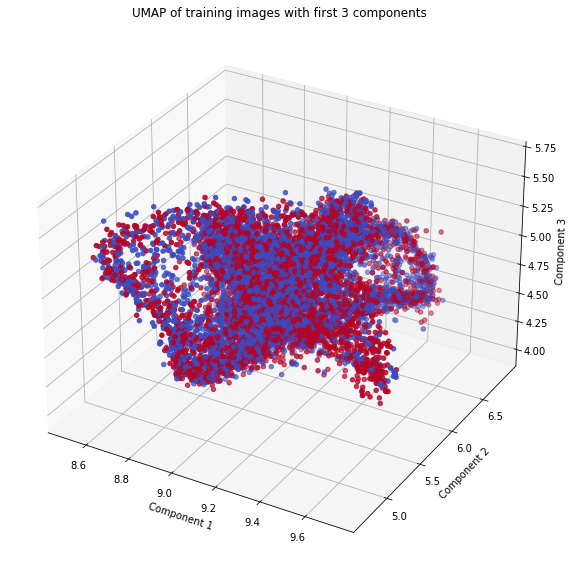

In [7]:
ax = plt.figure(figsize=(15, 10)).add_subplot(projection='3d')
ax.scatter(UMAP_train[:, 0], UMAP_train[:, 1], UMAP_train[:, 2], c=train_y, cmap="coolwarm")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title("UMAP of training images with first 3 components")
plt.show()

In [8]:
UMAP_X, UMAP_y = np.concatenate([UMAP_train, UMAP_val]), np.concatenate([train_y, val_y])

## XGB Classifier

In [9]:
xgb = XGBClassifier(objective= 'binary:logistic', seed=0)

params = {
    'max_depth':[3, 4, 5, 6],
    'n_estimators':[500, 600, 700, 800, 900, 1000],
    'learning_rate':[0.01, 0.05, 0.1, 0.5]
}

pds = PredefinedSplit(test_fold=np.repeat([-1, 0], [10000, 2000]))

xgb_grid = GridSearchCV(xgb, params, scoring='roc_auc', n_jobs=-1, cv=pds)

xgb_grid.fit(UMAP_X, UMAP_y)

[12:11:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_we...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=0, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [500, 600, 700, 800, 900, 1000]},
             scoring='roc_auc')

<AxesSubplot:>

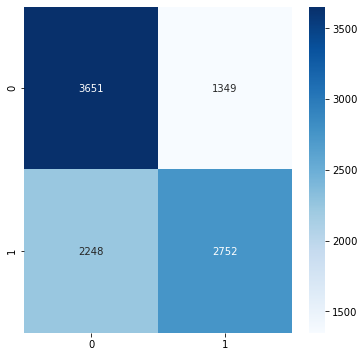

In [10]:
xgb_clf = xgb_grid.best_estimator_

ytrain_pred = xgb_clf.predict(UMAP_train)
train_cm = confusion_matrix(train_y, ytrain_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap="Blues")

In [11]:
print("Train accuracy:", round(accuracy_score(train_y, ytrain_pred), 3))
print("Train F1 score:", round(f1_score(train_y, ytrain_pred), 3))
print("Train precision:", round(precision_score(train_y, ytrain_pred), 3))
print("Train recall:", round(recall_score(train_y, ytrain_pred), 3))

Train accuracy: 0.64
Train F1 score: 0.605
Train precision: 0.671
Train recall: 0.55


<AxesSubplot:>

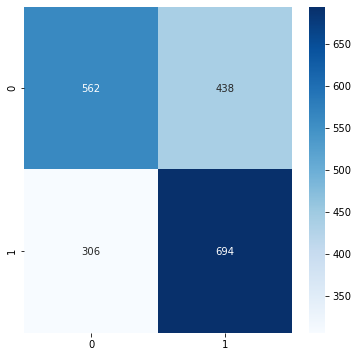

In [12]:
yval_pred = xgb_clf.predict(UMAP_val)
val_cm = confusion_matrix(val_y, yval_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap="Blues")

In [13]:
print("Validation accuracy:", round(accuracy_score(val_y, yval_pred), 3))
print("Validation F1 score:", round(f1_score(val_y, yval_pred), 3))
print("Validation precision:", round(precision_score(val_y, yval_pred), 3))
print("Validation recall:", round(recall_score(val_y, yval_pred), 3))

Validation accuracy: 0.628
Validation F1 score: 0.651
Validation precision: 0.613
Validation recall: 0.694


<AxesSubplot:>

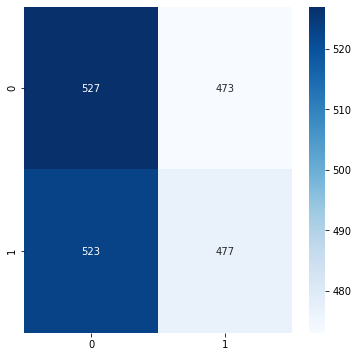

In [14]:
ytest_pred = xgb_clf.predict(UMAP_test)
test_cm = confusion_matrix(test_y, ytest_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="Blues")

In [15]:
print("Test accuracy:", round(accuracy_score(test_y, ytest_pred), 3))
print("Test F1 score:", round(f1_score(test_y, ytest_pred), 3))
print("Test precision:", round(precision_score(test_y, ytest_pred), 3))
print("Test recall:", round(recall_score(test_y, ytest_pred), 3))

Test accuracy: 0.502
Test F1 score: 0.489
Test precision: 0.502
Test recall: 0.477


## Random Forest Classifier

In [16]:
rf = RandomForestClassifier(random_state=0)

params = {
    'n_estimators':[250, 500, 750, 1000],
    'max_depth': [3, 4, 5, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

rf_grid = GridSearchCV(rf, params, scoring='roc_auc', cv=pds, n_jobs=-1)

rf_grid.fit(UMAP_X, UMAP_y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [250, 500, 750, 1000]},
             scoring='roc_auc')

<AxesSubplot:>

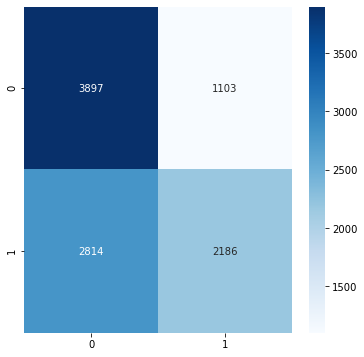

In [17]:
rf_clf = rf_grid.best_estimator_

ytrain_pred = rf_clf.predict(UMAP_train)
train_cm = confusion_matrix(train_y, ytrain_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap="Blues")

In [18]:
print("Train accuracy:", round(accuracy_score(train_y, ytrain_pred), 3))
print("Train F1 score:", round(f1_score(train_y, ytrain_pred), 3))
print("Train precision:", round(precision_score(train_y, ytrain_pred), 3))
print("Train recall:", round(recall_score(train_y, ytrain_pred), 3))

Train accuracy: 0.608
Train F1 score: 0.527
Train precision: 0.665
Train recall: 0.437


<AxesSubplot:>

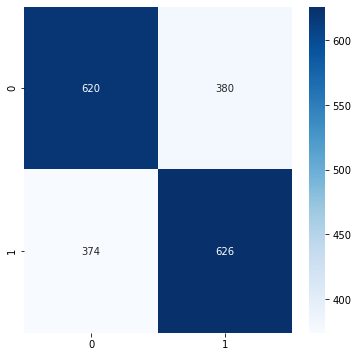

In [19]:
yval_pred = rf_clf.predict(UMAP_val)
val_cm = confusion_matrix(val_y, yval_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap="Blues")

In [20]:
print("Validation accuracy:", round(accuracy_score(val_y, yval_pred), 3))
print("Validation F1 score:", round(f1_score(val_y, yval_pred), 3))
print("Validation precision:", round(precision_score(val_y, yval_pred), 3))
print("Validation recall:", round(recall_score(val_y, yval_pred), 3))

Validation accuracy: 0.623
Validation F1 score: 0.624
Validation precision: 0.622
Validation recall: 0.626


<AxesSubplot:>

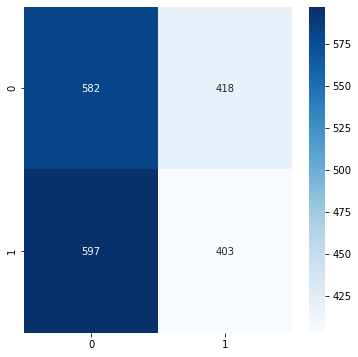

In [21]:
ytest_pred = rf_clf.predict(UMAP_test)
test_cm = confusion_matrix(test_y, ytest_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="Blues")

In [22]:
print("Test accuracy:", round(accuracy_score(test_y, ytest_pred), 3))
print("Test F1 score:", round(f1_score(test_y, ytest_pred), 3))
print("Test precision:", round(precision_score(test_y, ytest_pred), 3))
print("Test recall:", round(recall_score(test_y, ytest_pred), 3))

Test accuracy: 0.492
Test F1 score: 0.443
Test precision: 0.491
Test recall: 0.403
